# **Advanced Lane Finding** 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle

%matplotlib inline

In [2]:
save_images = True
repo_folder = './'
cam_cal_folder =  './camera_cal/'
test_folder = './test_images/'
out_img_folder = './output_images/'
chal_folder = './chal_images/'

In [3]:
def BGR2RGB(img):
    b, g, r = None, None, None
    b, g, r = cv2.split(img)
    return cv2.merge([r,g,b])

# 1. Camera Calibration

In [4]:
def calibrate_save(cam_cal_folder):
    cal_nx = 9
    cal_ny = 6
    cal_sh = (cal_nx, cal_ny)
    images = glob.glob(cam_cal_folder + 'calibration*.jpg')

    # Arrays to store object points and image points from all the images

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0),(1,0,0),(2,0,0),...,(7,5,0)
    objp = np.zeros((cal_ny*cal_nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:cal_nx,0:cal_ny].T.reshape(-1,2) # x,y coordinates

    for imgpath in images:
        img = cv2.imread(imgpath)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, cal_sh, None)

        # If corners are found, add object points, image points
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
                
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open(cam_cal_folder + 'calibration_pickle.p', 'wb'))
       
    return mtx, dist
    

In [5]:
# Read in the saved objpoints and imgpoints
def calibrate_load():
    try:
        dist_pickle = pickle.load(open(cam_cal_folder + 'calibration_pickle.p', 'rb'))
        mtx = dist_pickle['mtx']
        dist = dist_pickle['dist']
        return mtx, dist
    except:
        return None, None

In [6]:
mtx, dist = calibrate_load()
if mtx is None or dist is None:
    mtx, dist = calibrate_save(cam_cal_folder)    

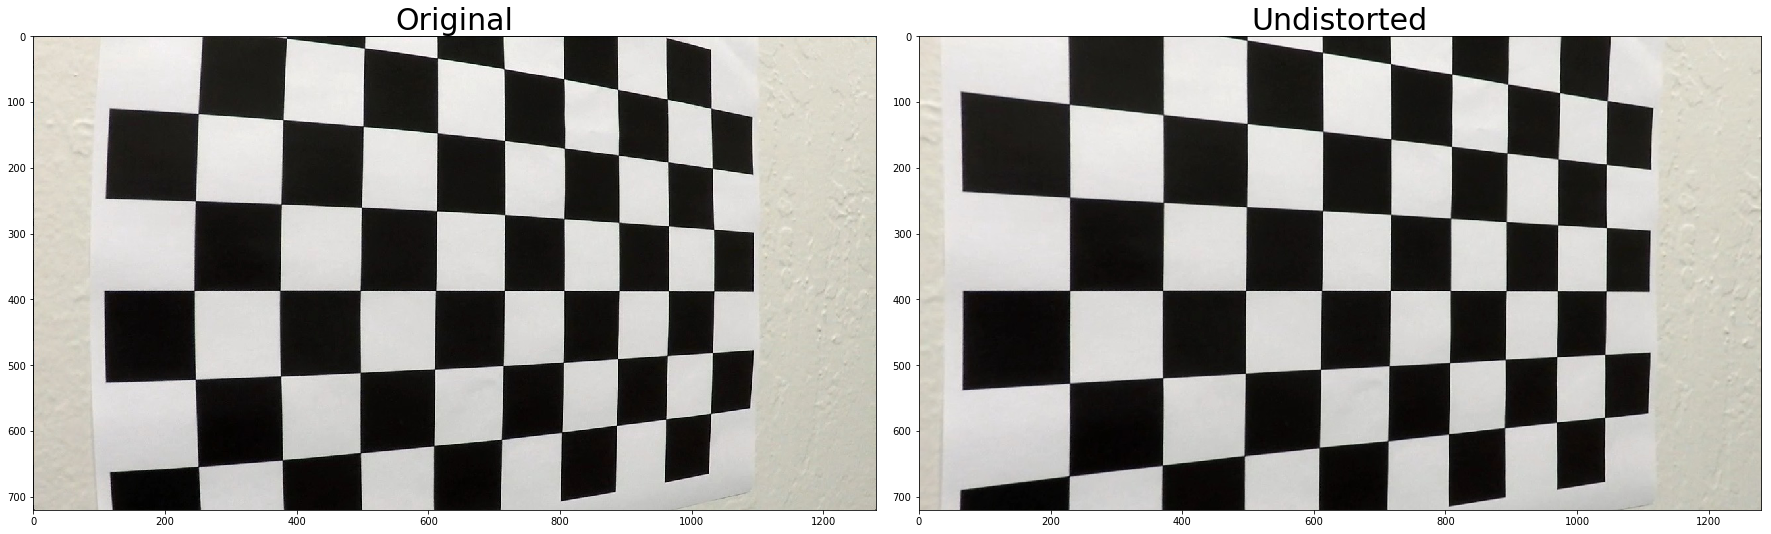

In [7]:
cal_img = mpimg.imread(cam_cal_folder + 'calibration5.jpg')
cal_undst = cv2.undistort(cal_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(cal_undst)
ax2.set_title('Undistorted', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
if save_images:
    plt.savefig(out_img_folder + 'undistort_output.png')

# 2. Distortion Correction

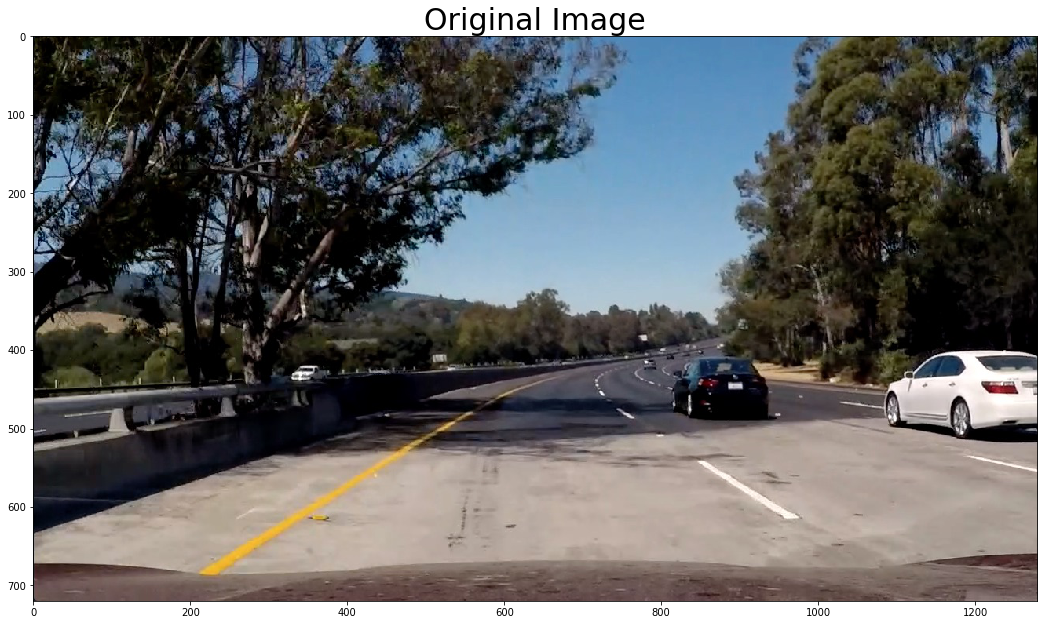

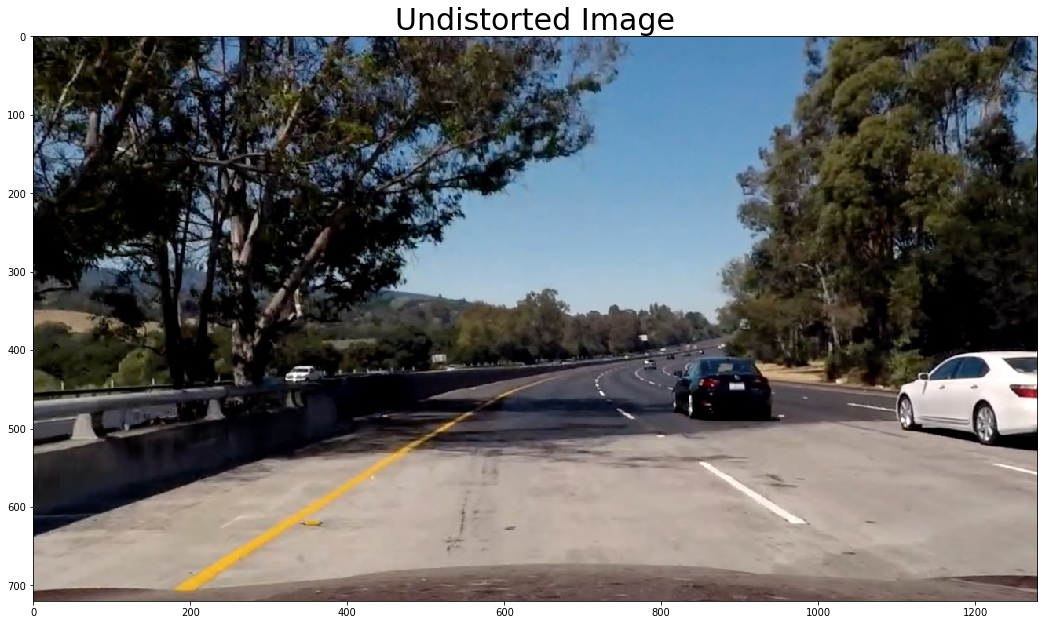

In [8]:
image_t5 = mpimg.imread(test_folder + 'test5.jpg')
undst_t5 = cv2.undistort(image_t5, mtx, dist, None, mtx)
plt.figure(figsize=(18,12))
plt.title('Original Image', fontsize=30)
plt.imshow(image_t5)
plt.figure(figsize=(18,12))
plt.title('Undistorted Image', fontsize=30)
plt.imshow(undst_t5)
if save_images:
    cv2.imwrite(out_img_folder + 'undistorted.jpg', BGR2RGB(undst_t5))

# 3. Color/gradient threshold

In [9]:
def yellow_white(img, draw_image=False):
    """ Filters yellow or white pixels
    """
    R = img[:,:,0]
    G = img[:,:,0]
    B = img[:,:,0]
    
    yellow_lower = np.array([140, 50, 0], dtype=np.uint8)
    yellow_upper = np.array([255, 150, 135], dtype=np.uint8)        

    white_lower = np.array([170, 170, 170], dtype=np.uint8)
    white_upper = np.array([255, 255, 255], dtype=np.uint8)    
    
    mask = np.zeros_like(R)
    mask[((((R >= yellow_lower[0]) & (R <= yellow_upper[0])) & 
           ((G >= yellow_lower[1]) & (G <= yellow_upper[1])) &
           ((B >= yellow_lower[2]) & (B <= yellow_upper[2]))) |
          (((R >= white_lower[0]) & (R <= white_upper[0])) & 
           ((G >= white_lower[1]) & (G <= white_upper[1])) &
           ((B >= white_lower[2]) & (B <= white_upper[2])))          
         )] = 1
    
    if draw_image:
        plt.figure()
        plt.imshow(mask, cmap='gray')
    return mask

In [10]:
# Takes an image, gradient orientation, and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobelx)
    if orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)        
        abs_sobel = np.absolute(sobely)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the result
    return binary_output

In [11]:
# Return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [12]:
# Threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [13]:
def color_threshold(img, sthr=(100, 255), vthr=(50,255), draw_image=False):
    # Convert to HLS space and take the S channel
    # Create a binary image of ones where threshold is met, zeros otherwise
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    S = hls[:,:,2]
    sbin = np.zeros_like(S)
    sbin[(S >= sthr[0]) & (S <= sthr[1])] = 1
    
    # Convert to HSV space and take the V channel
    # Create a binary image of ones where threshold is met, zeros otherwise    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]
    vbin = np.zeros_like(V)
    vbin[(V >= vthr[0]) & (V <= vthr[1])] = 1
    
    # Combine binary image of S channel of HLS, and 
    # binary image of V channel of HSV
    output = np.zeros_like(S)
    output[(sbin == 1) & (vbin == 1)] = 1
    
    if draw_image:
        f, ax = plt.subplots(2, 2, figsize=(12, 9))
        f.tight_layout()
        ax[0,0].imshow(img)
        ax[0,0].set_title('Original', fontsize=20)
        ax[0,1].imshow(output, cmap='gray')
        ax[0,1].set_title('Combined', fontsize=20)
        ax[1,0].imshow(sbin, cmap='gray')
        ax[1,0].set_title('Binary S', fontsize=20)
        ax[1,1].imshow(vbin, cmap='gray')
        ax[1,1].set_title('Binary V', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
        
    return output

In [14]:
def color_transform_bxsv(img, thresholds=None, draw_image=False, draw_steps=False):
    """
       In order to eliminate lines that are not yellow or white:
       Calculate X gradient
       Calculate S threshold and Y threshold
       Calculate RGB Thresholds for yellow and white
       Combine X, SY with or
       Cobmine XorSY, RGB with and
    """   
    if thresholds is None:
        xthr = (12, 255)
        sthr = (100, 255)
        vthr = (170, 255)
    else:
        xthr = thresholds[0]
        sthr = thresholds[1]
        vthr = thresholds[2]
    prep = np.zeros_like(img[:, :, 0])
    gradsb = np.zeros_like(img[:,:,0])
    masked = yellow_white(img, draw_image=draw_steps)    
    gradx = abs_sobel_thresh(img, orient='x', thresh=xthr)
    c_binary = color_threshold(img, sthr=sthr, vthr=vthr, draw_image=draw_steps)
    gradsb[(gradx == 1) | (c_binary == 1)] = 1 
    prep[(gradsb == 1) & (masked == 1)] = 1
    if draw_image:
        plt.figure(figsize=(18, 12))
        plt.title('gradx', fontsize=30)
        plt.imshow(gradx, cmap='gray')
        plt.figure(figsize=(18, 12))
        plt.title('masked', fontsize=30)
        plt.imshow(masked, cmap='gray')
        plt.figure(figsize=(18, 12))
        plt.title('gradsb', fontsize=30)
        plt.imshow(gradsb, cmap='gray') 
        plt.figure(figsize=(18, 12))
        plt.title('c_binary', fontsize=30)
        plt.imshow(c_binary, cmap='gray')
        plt.figure(figsize=(18, 12))
        plt.title('prep', fontsize=30)
        plt.imshow(prep, cmap='gray')         
    return prep

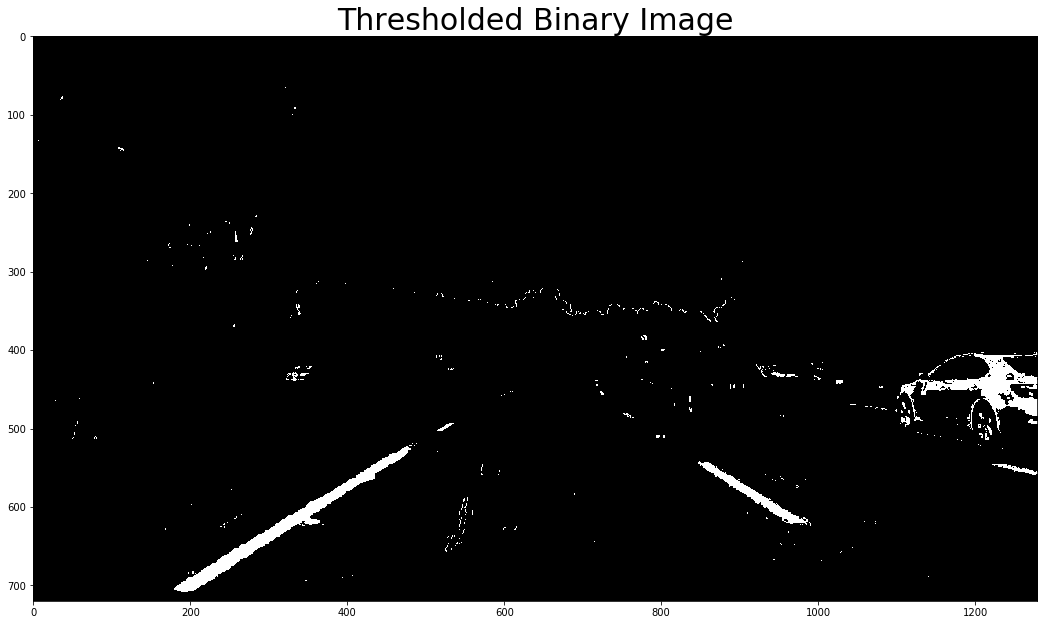

In [15]:
ctr_t5 = color_transform_bxsv(undst_t5)
plt.figure(figsize=(18,12))
plt.title('Thresholded Binary Image', fontsize=30)
plt.imshow(ctr_t5, cmap='gray')
if save_images:
    cv2.imwrite(out_img_folder + 'thresholded.jpg', ctr_t5 * 255)

# 4. Perspective transform

In [16]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

def perspective(img, draw_image=False):
    # work on defining perspective transformation area
    is0 = img.shape[0]
    is1 = img.shape[1]
    img_size = (is1, is0)

    bot_width = .45  # percent of bottom trapizoid height
    mid_width = .08  # percent of middle trapizoid height
    height_pct = .65  # percent for trapizoid height
    bottom_trim = .95  # percent from top to bottom to avoid car hood    
        
    midxb = 0.50
    midxt = 0.50
    tlx = is1 * (midxt - mid_width / 2)  # top left x
    trx = is1 * (midxt + mid_width / 2)  # top right x
    brx = is1 * (midxb + bot_width / 2)  # bottom right x
    blx = is1 * (midxb - bot_width / 2)  # bottom left x
    src = np.float32([[tlx, is0 * height_pct],
                      [trx, is0 * height_pct],
                      [brx, is0 * bottom_trim],
                      [blx, is0 * bottom_trim]])
    offset = is1 * .25
    
    dst = np.float32([[offset, 0],
                      [is1 - offset, 0],
                      [is1 - offset, is0],
                      [offset, is0]])
    
    if draw_image:
    
        codes = [Path.MOVETO,
                 Path.LINETO,
                 Path.LINETO,
                 Path.LINETO,
                 Path.LINETO,
                 ]
        path = Path(np.concatenate((src, [src[0,:]]), axis=0), codes)
        patch_src = patches.PathPatch(path, lw=3, fill=False, color='blue')    
        
        path = Path(np.concatenate((dst, [dst[0,:]]), axis=0), codes)
        patch_dst = patches.PathPatch(path, lw=3, fill=False, color='blue')
    
 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    if draw_image:
        fig = plt.figure()
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,9))

        ax1.set_title('Source image')
        ax1.imshow(img, cmap='gray')
        ax1.add_patch(patch_src)
        ax2.set_title('Warped image')
        ax2.imshow(warped, cmap='gray')
        ax2.add_patch(patch_dst)
        if save_images and draw_image:
            plt.savefig(out_img_folder + 'warped_straight_lines.jpg')
        
    return warped, M, Minv


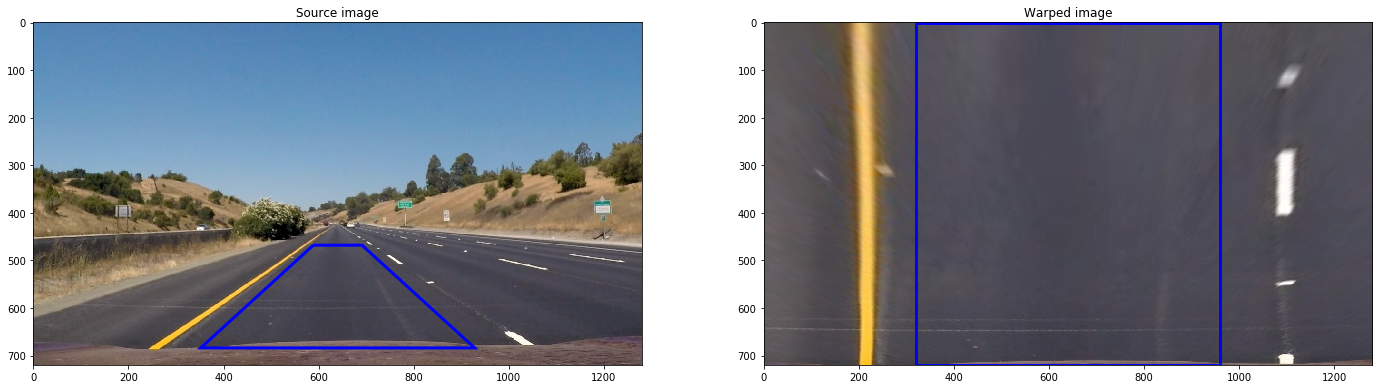

In [17]:
image_s1 = mpimg.imread(test_folder + 'straight_lines1.jpg')
warped_s1, M_s1, Minv_s1 = perspective(image_s1, True)

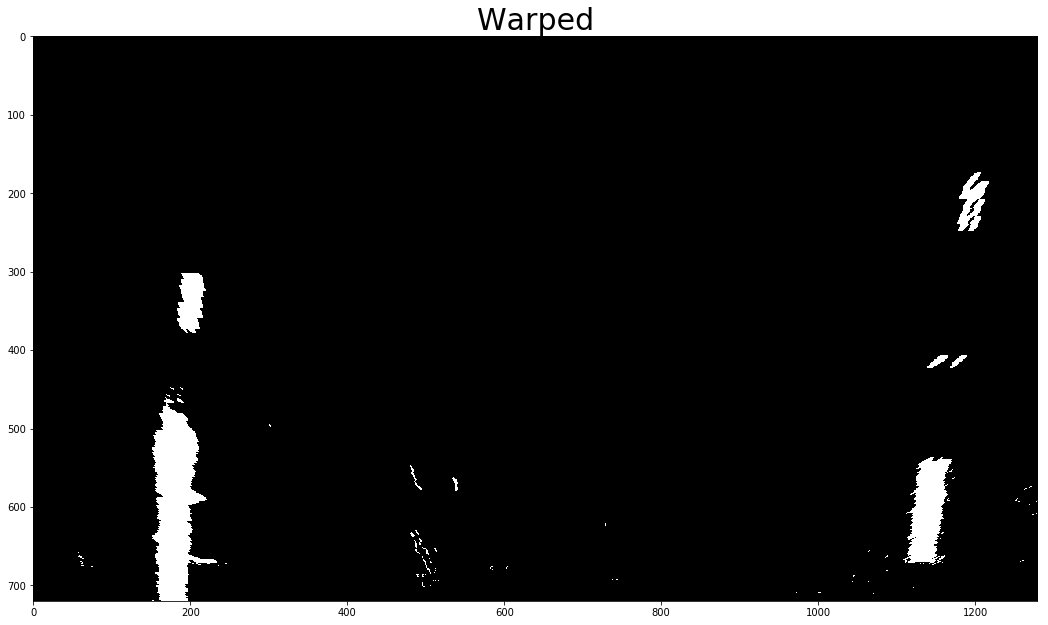

In [18]:
warped_t5, M_t5, Minv_t5 = perspective(ctr_t5, False)
plt.figure(figsize=(18,12))
plt.title('Warped', fontsize=30)
plt.imshow(warped_t5, cmap='gray')

# 5. Detect lane lines

In [19]:
class tracker():
    # When starting a new instance please be sure 
    # to specify all unassigned variables
    def __init__(self, width, height, margin, ym=1, xm=1):
        
        # list that stores all the past (left, right) center set values
        # used for smoothing the output 
        self.recent_centers = []
        
        # the window pixel width of the center values, 
        # used to count pixels inside center windows to determine curve values
        self.window_width = width
        
        # the window pixel width of the center values,
        # used to count pixels inside center windows to determine 
        # curve values breaks the image into vertical levels
        self.window_height = height
        
        # The pixel distance in both directions to slide 
        self.margin = margin
        
        self.ym_per_pix = ym  # meters per pixel in vertical axis
        
        self.xm_per_pix = xm  # meters per pixel in horizontal axis
        
        # Previous A, B, C values for left lane Polynomial (pixel)
        self.left_fit = None
        # Previous A, B, C values for right lane Polynomial (pixel)
        self.right_fit = None
        # Previous A, B, C values for left lane Polynomial (meter)
        self.curve_fit_cr_l = None
        # Previous A, B, C values for right lane Polynomial (meter)
        self.curve_fit_cr_r = None
        # Previous image has a successful fit or not
        self.fit = False
        # The array of distances between two lanes at bottom
        self.bottom_distance = []
        # The array of distances between two lanes at top
        self.top_distance = []
        # Count of consecutive images that lanes are not detected
        # Reset to zero on a successful fit 
        self.undetected = 0
        
    # the main tracking function for finding and storing lane segment positions
    def find_window_centroids(self, warped):
        window_width = self.window_width
        window_height = self.window_height
        margin_left = self.margin
        margin_right = self.margin
         
        # Store the (left, right) window centroid positions per level
        left_centroids = []
        right_centroids = []
        # Create our window template that we will use for convolutions
        window = np.ones(window_width) 

        ws0 = warped.shape[0]
        ws1 = warped.shape[1]
        

        # First find the two starting positions for the left and right lane by 
        # using np.sum to get the vertical image slice and then np.convolve
        # the vertical image slice with the window template
        # Sum half bottom of image to get slice
        l_warped = warped[int(ws0/2):,:int(ws1/2)]
        l_sum = np.sum(l_warped, axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_warped = warped[int(ws0/2):,int(ws1/2):]
        r_sum = np.sum(r_warped, axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(ws1/2)
        res_yvals = np.arange(ws0 - (window_height / 2), 0, -window_height)
        left_centroids.append((l_center, res_yvals[0]))
        right_centroids.append((r_center, res_yvals[0]))
        
        # Add what we found for the first layer
        offset = window_width / 2
        
        # Go through each layer looking for max pixel locations
        for level in range(1, (int)(ws0/window_height)):
            # convolve the window into the vertical slice of the image
            warped_layer = warped[int(ws0-(level+1)*window_height):int(ws0-level*window_height),:]
            image_layer = np.sum(warped_layer, axis=0)
            conv_signal = np.convolve(window, image_layer)
              
                
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is 
            # at right side of window, not center of window
            offset = window_width / 2
            l_min_index = int(max(l_center+offset-margin_left,0))
            l_max_index = int(min(l_center+offset+margin_left,ws1))
            l_conv_signal = conv_signal[l_min_index:l_max_index]
            l_conv_signal0 = (l_conv_signal.shape[0] == 0)

            if not l_conv_signal0:            
                l_argmax = np.argmax(l_conv_signal)
                l_count = l_conv_signal[l_argmax]
                
            # If the number of the detected points is greater than 5
            # Add centroid, else skip for that window
            if not l_conv_signal0 and l_count > 5:
                l_min_offset = l_min_index-offset
                l_center = l_argmax + l_min_offset
                left_centroids.append((l_center, res_yvals[level]))

            
            # Find the best centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin_right,0))
            r_max_index = int(min(r_center+offset+margin_right,ws1))
            r_conv_signal = conv_signal[r_min_index:r_max_index]
            r_conv_signal0 = (r_conv_signal.shape[0] == 0)
            
            if not r_conv_signal0:
                r_argmax = np.argmax(r_conv_signal)
                r_count = r_conv_signal[r_argmax]
                
            # If the number of the detected points is greater than 5
            # Add centroid, else skip for that window                
            if not r_conv_signal0 and r_count > 5:
                r_min_offset = r_min_index-offset
                r_center = r_argmax + r_min_offset
                right_centroids.append((r_center, res_yvals[level]))

        return left_centroids, right_centroids


In [20]:
def window_mask(width, height, img_ref, centerx, centery):
    output = np.zeros_like(img_ref)
    is0 = img_ref.shape[0]
    is1 = img_ref.shape[1]
    y_start = centery
    y_end = y_start + height
    output[y_start:y_end,
           max(0, int(centerx - width)):min(int(centerx + width), is1)] = 1
    return output

# 6. Determine the lane curvature

In [21]:
def process_image(img, img_name="", draw_image=False):
    is0 = img.shape[0]
    is1 = img.shape[1]
    img_size = (is1, is0)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    color_t = color_transform_bxsv(undst)
    warped, M, Minv = perspective(color_t)
    
    window_width = curve_centers.window_width
    window_height = curve_centers.window_height
    margin = curve_centers.margin
    
    ym_per_pix = curve_centers.ym_per_pix
    xm_per_pix = curve_centers.xm_per_pix
    
    ws0 = warped.shape[0]
    ws1 = warped.shape[1]
    yvals = range(0, ws0)
    
    if (curve_centers.fit):
        left_fit = curve_centers.left_fit
        right_fit = curve_centers.right_fit
    else:
        left_centroids, right_centroids = curve_centers.find_window_centroids(warped)
        
        if draw_image:
            l_points = np.zeros_like(warped)
            r_points = np.zeros_like(warped)
        # Points used to find the left and right lanes
        rightx = []
        leftx = []
        righty = []
        lefty = []
        # Go through each level and draw the windows
        for level in range(0, len(left_centroids)):
            leftx_window = left_centroids[level][0]
            leftx.append(leftx_window)
            lefty_window = left_centroids[level][1]
            lefty.append(lefty_window)
            if draw_image:
                l_mask = window_mask(window_width, window_height,
                                    warped, leftx_window, lefty_window)
                l_points[(l_points == 1) | (l_mask == 1)] = 1
        for level in range(0, len(right_centroids)):
            rightx_window = right_centroids[level][0]
            rightx.append(rightx_window)
            righty_window = right_centroids[level][1]
            righty.append(righty_window)
            if draw_image:
                r_mask = window_mask(window_width, window_height,
                                    warped, rightx_window, righty_window)
                r_points[(r_points == 1) | (r_mask == 1)] = 1
                

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    binary_warped = warped


    # New warped binary image from the next frame of video 
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if leftx.shape[0] > 0 and lefty.shape[0] > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        resl_ym = np.array(lefty,np.float32)*ym_per_pix
        resl_xm = np.array(leftx, np.float32)*xm_per_pix
        
        curve_fit_cr_l = np.polyfit(resl_ym,resl_xm,2)
        curve_centers.fit = True
    else:
        curve_fit_cr_l = curve_centers.curve_fit_cr_l
        curve_fit_cr_r = curve_centers.curve_fit_cr_r
        curve_centers.fit = False
        left_fit = curve_centers.left_fit

    if rightx.shape[0] > 0 and righty.shape[0] > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        resr_ym = np.array(righty,np.float32)*ym_per_pix
        resr_xm = np.array(rightx, np.float32)*xm_per_pix
        curve_fit_cr_r = np.polyfit(resr_ym,resr_xm,2)
    else:
        curve_centers.fit = False
        right_fit = curve_centers.right_fit

    # Sanity check for the lanes
    save_fit = True
    
    # Bottom point of the left lane and the right lane (y = 720)
    bottom_left = left_fit[0] * 720 * 720 + left_fit[1] * 720 + left_fit[2]
    bottom_right = right_fit[0] * 720 * 720 + right_fit[1] * 720 + right_fit[2]
    
    # Top point of the left lane and the right lane (y = 0)
    top_left = left_fit[2]
    top_right = right_fit[2]
    
    # Distances between left and right lanes
    bottom_distance = bottom_right - bottom_left
    top_distance = top_right - top_left
    
    # Average distances will be get from curve_centers instance
    average_bottom_distance = 0
    average_top_distance = 0
    bottom_error = 0
    top_error = 0
    len_pre_dist = len(curve_centers.bottom_distance)
    if len_pre_dist > 0:
        # Average distances of the last recorded 15 distances from previous images
        average_bottom_distance = np.mean(np.array(curve_centers.bottom_distance[-15:]))
        average_top_distance = np.mean(np.array(curve_centers.top_distance[-15:]))
        
        # Differences between distances of the current image, and the average distances
        bottom_error = np.absolute(bottom_distance - average_bottom_distance)
        top_error = np.absolute(top_distance - average_top_distance)
        
        # If the bottom error is greater than 50 or the top error is greater than 70
        # Don't save the fit
        if bottom_error >= 50 or top_error >= 70:
            save_fit = False
            
    if save_fit or curve_centers.undetected > 10:
        # If fit will be saved or lanes are not detected for more than 10 images
        # Use the calculated curves, and save them
        curve_centers.left_fit = left_fit        
        curve_centers.right_fit = right_fit

        curve_centers.curve_fit_cr_l = curve_fit_cr_l
        curve_centers.curve_fit_cr_r = curve_fit_cr_r

        curve_centers.bottom_distance.append(bottom_distance)
        curve_centers.top_distance.append(top_distance)
        curve_centers.undetected = 0
        save_fit = True
    else:
        # Don't add the distances to the list
        # Take curves from the previously saved curves                
        left_fit = curve_centers.left_fit
        right_fit = curve_centers.right_fit
        curve_centers.fit = False
        curve_centers.undetected += 1
        curve_fit_cr_l = curve_centers.curve_fit_cr_l
        curve_fit_cr_r = curve_centers.curve_fit_cr_r
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1 ] + window_width/2),axis =0), np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx[::-1]- window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    if draw_image:
        # Plot warped binary image
        # Plot color fit lines, lanes are colored on the warped image
        plt.figure(figsize=(18,12))
        plt.title('warped')
        plt.imshow(warped, cmap='gray')
        if save_images:
            cv2.imwrite(out_img_folder + 'warpedbinary.jpg', warped * 255)

        warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8)
        warpage *= 255
        warpage[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        warpage[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        plt.figure(figsize=(18,12))
        plt.title('Warpage Lanes')
        plt.imshow(warpage)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        if save_images:
            plt.savefig(out_img_folder + 'color_fit_lines.jpg')        

    # Plot the lanes, reverse perspective transform the lanes
    # Combine lanes with the original image
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road, [inner_lane], color=[0,255,0])
    cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])    
    
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 0.5, 0.0)

    # Calculate the radius values of the left lane and the right lane
    curverad_l = ((1 + (2*curve_fit_cr_l[0]*yvals[-1]*ym_per_pix + curve_fit_cr_l[1])**2)**1.5) / np.absolute(2*curve_fit_cr_l[0])
    curverad_r = ((1 + (2*curve_fit_cr_r[0]*yvals[-1]*ym_per_pix + curve_fit_cr_r[1])**2)**1.5) / np.absolute(2*curve_fit_cr_r[0])
    
    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - ws1 / 2) * xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
        
    # Draw the text showing curvature, offset, and speed
    cv2.putText(result, 'Radius of Curvature Left: ' +str(round(curverad_l,3))+'(m) Right: ' +str(round(curverad_r,3))+'(m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    if draw_image:
        if save_images:
            cv2.imwrite(out_img_folder + 'example_output.jpg', BGR2RGB(result))
    return result

/home/seyfi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


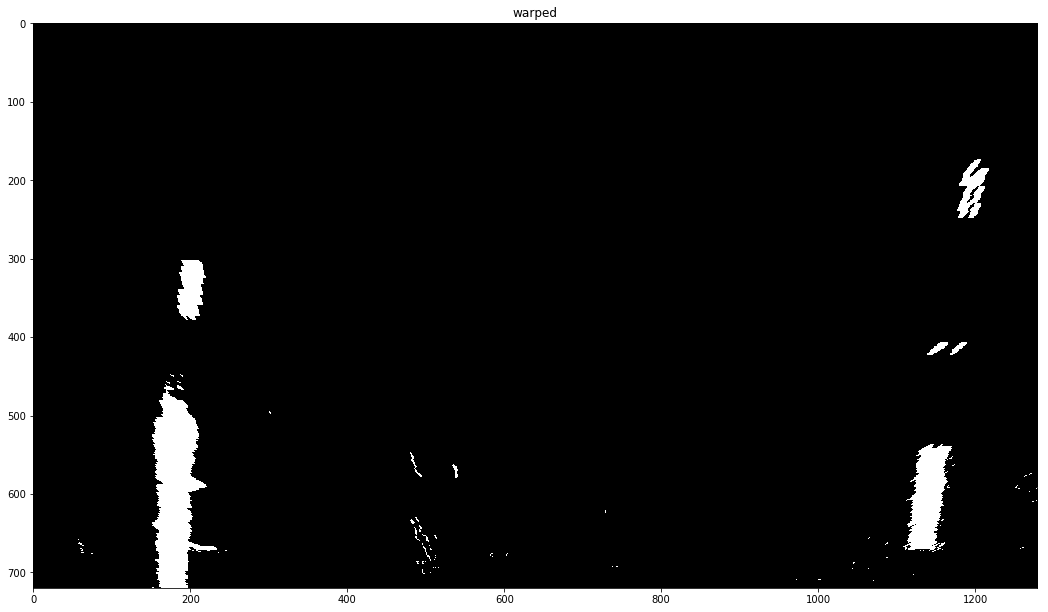

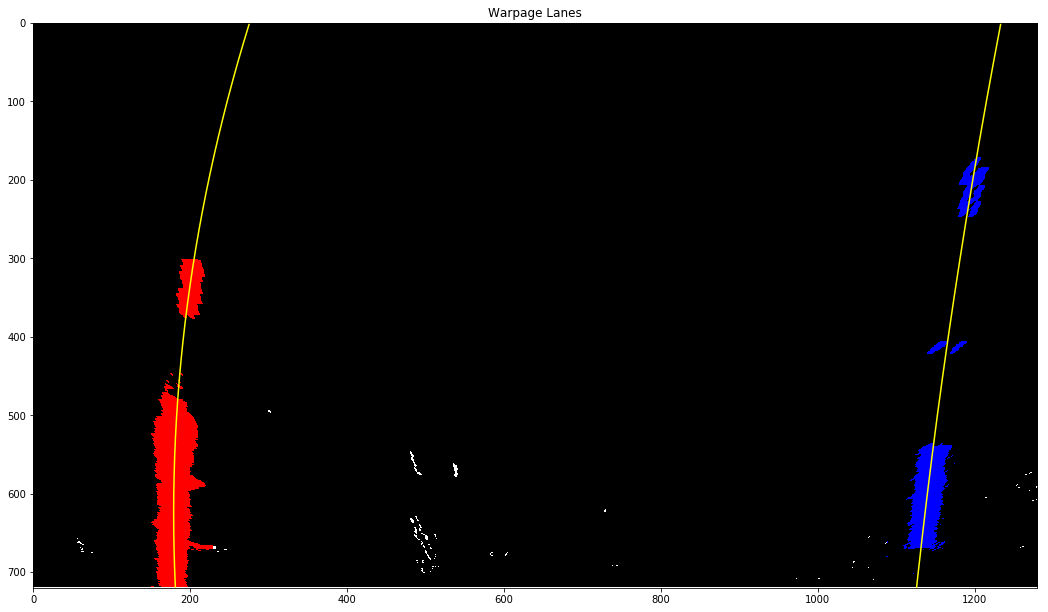

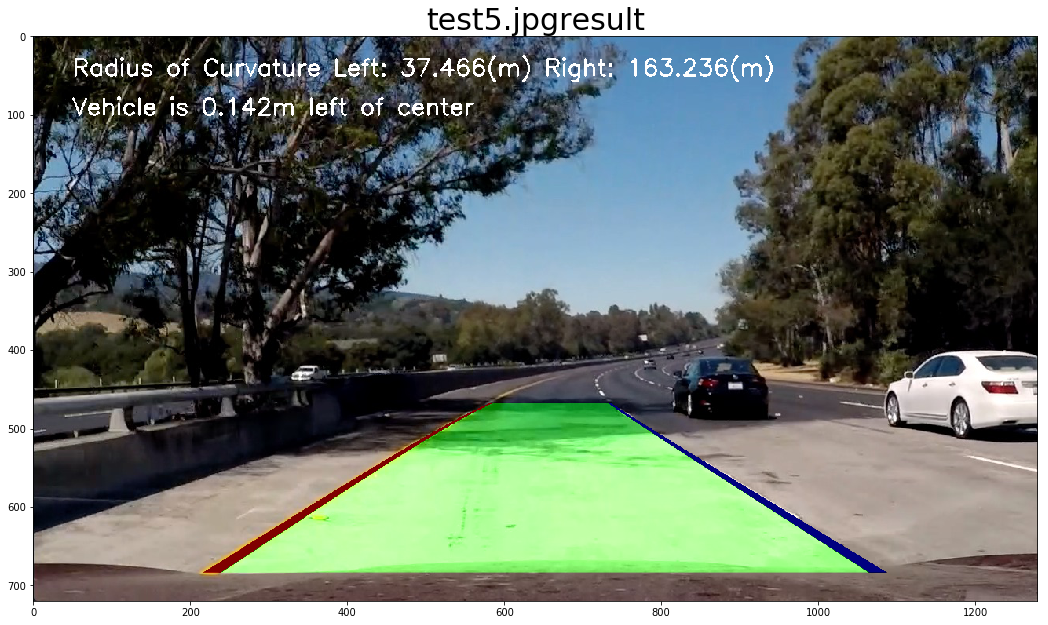

In [22]:
window_width = 25
window_height = 80
curve_centers = tracker(width=window_width, height=window_height,
                        margin=50, ym=10 / 720, xm=4 / 384)
# Make a list of test images
images = []
#images += glob.glob(test_folder + '/straight_lines*.jpg')
#images += glob.glob(test_folder + '/test*.jpg')
#images.append(test_folder + 'straight_lines1.jpg')
#images.append(test_folder + 'test1.jpg')
images.append(test_folder + 'test5.jpg')

if len(images) > 5:
    draw_image = False
else:
    draw_image = True

for idx, fname in enumerate(images):
    """
    curve_centers = tracker(width=window_width, height=window_height,
                        margin=50, ym=10 / 720, xm=4 / 384,
                        smooth_factor=15)    
    """
    img_paths = fname.split('/')
    imgpath = fname
    fidx = img_paths[-1][2:-4]
    img = mpimg.imread(imgpath)
    result = process_image(img, img_name=img_paths[-1], draw_image=draw_image)
    plt.figure(figsize=(18, 12))
    plt.title(img_paths[-1] + 'result', fontsize=30)
    plt.imshow(result)
    if idx >= 10:
        break


## 4. Video

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
curve_centers = tracker(width=25, height=80,
                    margin=50, ym=10 / 720, xm=4 / 384)    

output_project_video = out_img_folder + 'output_tracked.mp4'
input_project_video = repo_folder + 'project_video.mp4'

clip1 = VideoFileClip(input_project_video)
video_clip = clip1.fl_image(process_image)  # COLOR IMAGES
video_clip.write_videofile(output_project_video, audio=False)

[MoviePy] >>>> Building video ./output_images/output_tracked.mp4
[MoviePy] Writing video ./output_images/output_tracked.mp4


100%|█████████▉| 1260/1261 [02:52<00:00,  7.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_tracked.mp4 



In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project_video))

In [26]:
curve_centers = tracker(width=25, height=80,
                    margin=50, ym=10 / 720, xm=4 / 384)    

output_challange_video = out_img_folder + 'challenge_tracked.mp4'
input_challange_video = repo_folder + 'challenge_video.mp4'

clip1 = VideoFileClip(input_challange_video)
video_clip = clip1.fl_image(process_image)  # COLOR IMAGES
video_clip.write_videofile(output_challange_video, audio=False)

[MoviePy] >>>> Building video ./output_images/challenge_tracked.mp4
[MoviePy] Writing video ./output_images/challenge_tracked.mp4


100%|██████████| 485/485 [01:02<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/challenge_tracked.mp4 



In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challange_video))